# Data Preprocessing & Cleaning

### Importing necessary libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
import numpy as np

### Loading the datasets

In [5]:
ESG = pd.read_csv('ESG_Data.csv')
WEO = pd.read_csv('WEO_Data.csv')

### ESG Data Preprocessing & Cleaning
- Fixed missing 1000 rows growth rates
- Removed duplicates and rows with missing financial targets.
- Converted 'Year' to integer for consistent merging.
- Filled 1,000 missing Growth Rates using Industry Medians (to save data).

In [7]:
ESG = ESG.drop_duplicates()
ESG = ESG.dropna(subset=['Revenue', 'ProfitMargin', 'ESG_Overall'])
ESG['Year'] = ESG['Year'].astype(int)

industry_medians = ESG.groupby('Industry')['GrowthRate'].median()
ESG['GrowthRate'] = ESG['GrowthRate'].fillna(ESG['Industry'].map(industry_medians))

### WEO Data Preprocessing & Cleaning
- Turn year columns (2015, 2016...) into rows
- Force to string so we can edit the text
- Remove dots/commas, convert to a real number
- Sum GDP by Region & Year

In [9]:
WEO_Processed = WEO.melt(id_vars=['Country'], var_name='Year', value_name='GDP')

WEO_Processed['GDP'] = WEO_Processed['GDP'].astype(str)

WEO_Processed['GDP'] = WEO_Processed['GDP'].str.replace(',', '', regex=False)
WEO_Processed['GDP'] = WEO_Processed['GDP'].str.replace('.', '', regex=False)

WEO_Processed['GDP'] = pd.to_numeric(WEO_Processed['GDP'], errors='coerce')
WEO_Processed['Year'] = pd.to_numeric(WEO_Processed['Year'], errors='coerce')

### Regional Aggregation Strategy
ESG data is Regional (7 zones), GDP data is Country-level (196 nations).

- Step A (Mapping): Maped each of the 196 countries to one of the 7 ESG regions.
- Step B (Aggregation): Group and SUM GDP data by Region and Year.
- Step C (Merge): Join datasets on ['Region', 'Year'] keys.


In [11]:
country_map = {

    # --- NORTH AMERICA (2) ---
    'United States': 'North America', 'Canada': 'North America',

    # --- LATIN AMERICA (34) ---
    'Mexico': 'Latin America', 'Argentina': 'Latin America', 'Bolivia': 'Latin America',
    'Brazil': 'Latin America', 'Chile': 'Latin America', 'Colombia': 'Latin America',
    'Costa Rica': 'Latin America', 'Dominican Republic': 'Latin America', 'Ecuador': 'Latin America',
    'El Salvador': 'Latin America', 'Guatemala': 'Latin America', 'Haiti': 'Latin America',
    'Honduras': 'Latin America', 'Jamaica': 'Latin America', 'Nicaragua': 'Latin America',
    'Panama': 'Latin America', 'Paraguay': 'Latin America', 'Peru': 'Latin America',
    'Uruguay': 'Latin America', 'Venezuela': 'Latin America', 'Antigua and Barbuda': 'Latin America',
    'Aruba': 'Latin America', 'The Bahamas': 'Latin America', 'Barbados': 'Latin America',
    'Belize': 'Latin America', 'Dominica': 'Latin America', 'Grenada': 'Latin America',
    'Guyana': 'Latin America', 'St. Kitts and Nevis': 'Latin America', 'St. Lucia': 'Latin America',
    'St. Vincent and the Grenadines': 'Latin America', 'Suriname': 'Latin America',
    'Trinidad and Tobago': 'Latin America', 'Puerto Rico': 'Latin America',

    # --- EUROPE (45) ---
    'Albania': 'Europe', 'Andorra': 'Europe', 'Armenia': 'Europe', 'Austria': 'Europe',
    'Belarus': 'Europe', 'Belgium': 'Europe', 'Bosnia and Herzegovina': 'Europe',
    'Bulgaria': 'Europe', 'Croatia': 'Europe', 'Cyprus': 'Europe', 'Czech Republic': 'Europe',
    'Denmark': 'Europe', 'Estonia': 'Europe', 'Finland': 'Europe', 'France': 'Europe',
    'Georgia': 'Europe', 'Germany': 'Europe', 'Greece': 'Europe', 'Hungary': 'Europe',
    'Iceland': 'Europe', 'Ireland': 'Europe', 'Italy': 'Europe', 'Kosovo': 'Europe',
    'Latvia': 'Europe', 'Lithuania': 'Europe', 'Luxembourg': 'Europe', 'Malta': 'Europe',
    'Moldova': 'Europe', 'Montenegro': 'Europe', 'Netherlands': 'Europe', 'North Macedonia': 'Europe',
    'Norway': 'Europe', 'Poland': 'Europe', 'Portugal': 'Europe', 'Romania': 'Europe',
    'Russia': 'Europe', 'San Marino': 'Europe', 'Serbia': 'Europe', 'Slovak Republic': 'Europe',
    'Slovenia': 'Europe', 'Spain': 'Europe', 'Sweden': 'Europe', 'Switzerland': 'Europe',
    'Türkiye': 'Europe', 'Ukraine': 'Europe', 'United Kingdom': 'Europe',

    # --- ASIA (31) ---
    'Afghanistan': 'Asia', 'Bangladesh': 'Asia', 'Bhutan': 'Asia', 'Brunei Darussalam': 'Asia',
    'Cambodia': 'Asia', 'China': 'Asia', 'Hong Kong SAR': 'Asia', 'India': 'Asia',
    'Indonesia': 'Asia', 'Japan': 'Asia', 'Kazakhstan': 'Asia', 'Korea': 'Asia',
    'Kyrgyz Republic': 'Asia', 'Lao P.D.R.': 'Asia', 'Macao SAR': 'Asia', 'Malaysia': 'Asia',
    'Maldives': 'Asia', 'Mongolia': 'Asia', 'Myanmar': 'Asia', 'Nepal': 'Asia',
    'Pakistan': 'Asia', 'Philippines': 'Asia', 'Singapore': 'Asia', 'Sri Lanka': 'Asia',
    'Taiwan Province of China': 'Asia', 'Tajikistan': 'Asia', 'Thailand': 'Asia',
    'Timor-Leste': 'Asia', 'Turkmenistan': 'Asia', 'Uzbekistan': 'Asia', 'Vietnam': 'Asia',

    # --- OCEANIA (14) ---
    'Australia': 'Oceania', 'Fiji': 'Oceania', 'Kiribati': 'Oceania', 'Marshall Islands': 'Oceania',
    'Micronesia': 'Oceania', 'Nauru': 'Oceania', 'New Zealand': 'Oceania', 'Palau': 'Oceania',
    'Papua New Guinea': 'Oceania', 'Samoa': 'Oceania', 'Solomon Islands': 'Oceania',
    'Tonga': 'Oceania', 'Tuvalu': 'Oceania', 'Vanuatu': 'Oceania',

    # --- MIDDLE EAST (16) ---
    'Bahrain': 'Middle East', 'Islamic Republic of Iran': 'Middle East', 'Iraq': 'Middle East',
    'Israel': 'Middle East', 'Jordan': 'Middle East', 'Kuwait': 'Middle East',
    'Lebanon': 'Middle East', 'Oman': 'Middle East', 'Qatar': 'Middle East',
    'Saudi Arabia': 'Middle East', 'Syria': 'Middle East', 'United Arab Emirates': 'Middle East',
    'West Bank and Gaza': 'Middle East', 'Yemen': 'Middle East', 'Azerbaijan': 'Middle East',


    # --- AFRICA (54) ---
    'Algeria': 'Africa', 'Angola': 'Africa', 'Benin': 'Africa', 'Botswana': 'Africa',
    'Burkina Faso': 'Africa', 'Burundi': 'Africa', 'Cabo Verde': 'Africa', 'Cameroon': 'Africa',
    'Central African Republic': 'Africa', 'Chad': 'Africa', 'Comoros': 'Africa',
    'Democratic Republic of the Congo': 'Africa', 'Republic of Congo': 'Africa',
    'Côte d\'Ivoire': 'Africa', 'Djibouti': 'Africa', 'Egypt': 'Africa',
    'Equatorial Guinea': 'Africa', 'Eritrea': 'Africa', 'Eswatini': 'Africa',
    'Ethiopia': 'Africa', 'Gabon': 'Africa', 'The Gambia': 'Africa', 'Ghana': 'Africa',
    'Guinea': 'Africa', 'Guinea-Bissau': 'Africa', 'Kenya': 'Africa', 'Lesotho': 'Africa',
    'Liberia': 'Africa', 'Libya': 'Africa', 'Madagascar': 'Africa', 'Malawi': 'Africa',
    'Mali': 'Africa', 'Mauritania': 'Africa', 'Mauritius': 'Africa', 'Morocco': 'Africa',
    'Mozambique': 'Africa', 'Namibia': 'Africa', 'Niger': 'Africa', 'Nigeria': 'Africa',
    'Rwanda': 'Africa', 'São Tomé and Príncipe': 'Africa', 'Senegal': 'Africa',
    'Seychelles': 'Africa', 'Sierra Leone': 'Africa', 'Somalia': 'Africa', 'South Africa': 'Africa',
    'South Sudan': 'Africa', 'Sudan': 'Africa', 'Tanzania': 'Africa', 'Togo': 'Africa',
    'Tunisia': 'Africa', 'Uganda': 'Africa', 'Zambia': 'Africa', 'Zimbabwe': 'Africa'

}

WEO_Processed['Region'] = WEO_Processed['Country'].map(country_map)
WEO_Regional = WEO_Processed.groupby(['Region', 'Year'])['GDP'].sum().reset_index()

# Merge ESG & Regional WEO together
Merged = pd.merge(ESG, WEO_Regional, on=['Region', 'Year'], how='left')

# Summary Statistics


In [13]:
print("Dataset Shape:", Merged.shape)
print("\nGeneral Description:")
display(Merged.describe().round(2))

print("\nMissing Values Check:")
print(Merged.isnull().sum())

Dataset Shape: (11000, 17)

General Description:


,CompanyID,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption,GDP
count,11000.00,11000.00,11000.00,11000.00,11000.00,11000.00,11000.00,11000.00,11000.00,11000.00,1.100000e+04,11000.00,1.100000e+04,11000.00
mean,500.50,2020.00,4670.85,10.90,13380.62,4.83,54.62,56.42,55.66,51.77,1.271462e+06,560044.15,1.165839e+07,13010438.00
std,288.69,3.16,9969.95,8.76,39922.87,9.01,15.89,26.77,23.36,25.32,5.067760e+06,1565686.22,5.095836e+07,11926635.54
min,1.00,2015.00,35.90,-20.00,1.80,-36.00,6.30,0.00,0.00,0.00,2.042200e+03,1021.10,5.105500e+03,1441209.00
25%,250.75,2017.00,938.78,5.30,1098.52,-0.60,44.10,34.70,37.60,30.78,1.228529e+05,64884.68,3.069161e+05,2369150.00
50%,500.50,2020.00,1902.30,10.50,3096.45,4.70,54.60,55.60,55.15,52.10,2.920735e+05,203880.45,1.221745e+06,5317552.00
75%,750.25,2023.00,4342.62,16.30,9995.50,10.30,65.60,79.00,73.80,73.00,7.407311e+05,525187.98,5.616437e+06,24153713.00
max,1000.00,2025.00,180810.40,50.00,865271.70,38.00,98.80,100.00,100.00,100.00,1.741047e+08,52231416.40,1.741047e+09,35417782.00



Missing Values Check:
CompanyID            0
CompanyName          0
Industry             0
Region               0
Year                 0
Revenue              0
ProfitMargin         0
MarketCap            0
GrowthRate           0
ESG_Overall          0
ESG_Environmental    0
ESG_Social           0
ESG_Governance       0
CarbonEmissions      0
WaterUsage           0
EnergyConsumption    0
GDP                  0
dtype: int64


In [14]:
industry_stats = Merged.groupby('Industry')[['ProfitMargin', 'ESG_Overall', 'CarbonEmissions','WaterUsage','EnergyConsumption']].mean()
print("Average Performance by Industry:")
display(industry_stats.sort_values(by='ProfitMargin', ascending=False).round(2))

Average Performance by Industry:


,ProfitMargin,ESG_Overall,CarbonEmissions,WaterUsage,EnergyConsumption
Industry,,,,,
Technology,18.80,63.35,450418.73,270251.24,900837.45
Healthcare,15.45,57.25,335329.19,335329.19,670658.37
Finance,14.29,64.62,72050.45,36025.23,180126.14
Consumer Goods,10.81,54.83,340368.45,425460.56,1701842.26
Energy,10.55,49.01,8191264.71,2457379.41,81912647.04
Utilities,9.68,51.60,869341.08,543338.18,8693410.82
Manufacturing,8.49,50.46,623596.85,831462.46,10393280.77
Retail,5.49,55.68,129712.59,64856.29,259425.18
Transportation,5.37,46.03,650314.92,108385.82,2167716.39


In [15]:
region_stats = Merged.groupby('Region')[['GDP', 'ESG_Overall']].mean()
print("Average GDP and ESG by Region:")
display(region_stats.sort_values(by='ESG_Overall', ascending=False).round(2))

Average GDP and ESG by Region:


,GDP,ESG_Overall
Region,,
Europe,22331569.91,67.87
Oceania,1778060.64,62.44
North America,25279522.64,61.22
Asia,30290135.36,51.90
Latin America,5439406.73,50.52
Africa,2434908.27,44.51
Middle East,2743236.64,43.44


# VISUALIZATIONS


### Scatter plot of ESG Score vs. Profit Margin


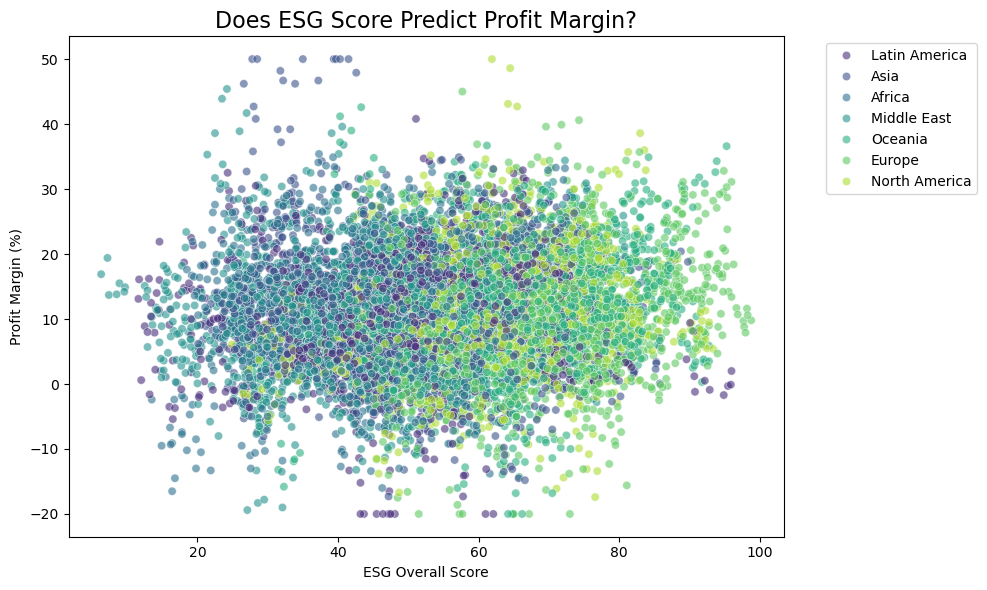

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Merged, x='ESG_Overall', y='ProfitMargin', hue='Region', alpha=0.6, palette='viridis')
plt.title('Does ESG Score Predict Profit Margin?', fontsize=16)
plt.xlabel('ESG Overall Score')
plt.ylabel('Profit Margin (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### A 3-panel dashboard of ESG Score vs. Environmental Impact
- Carbon Emissions
- Water Usage
- Energy Consumption


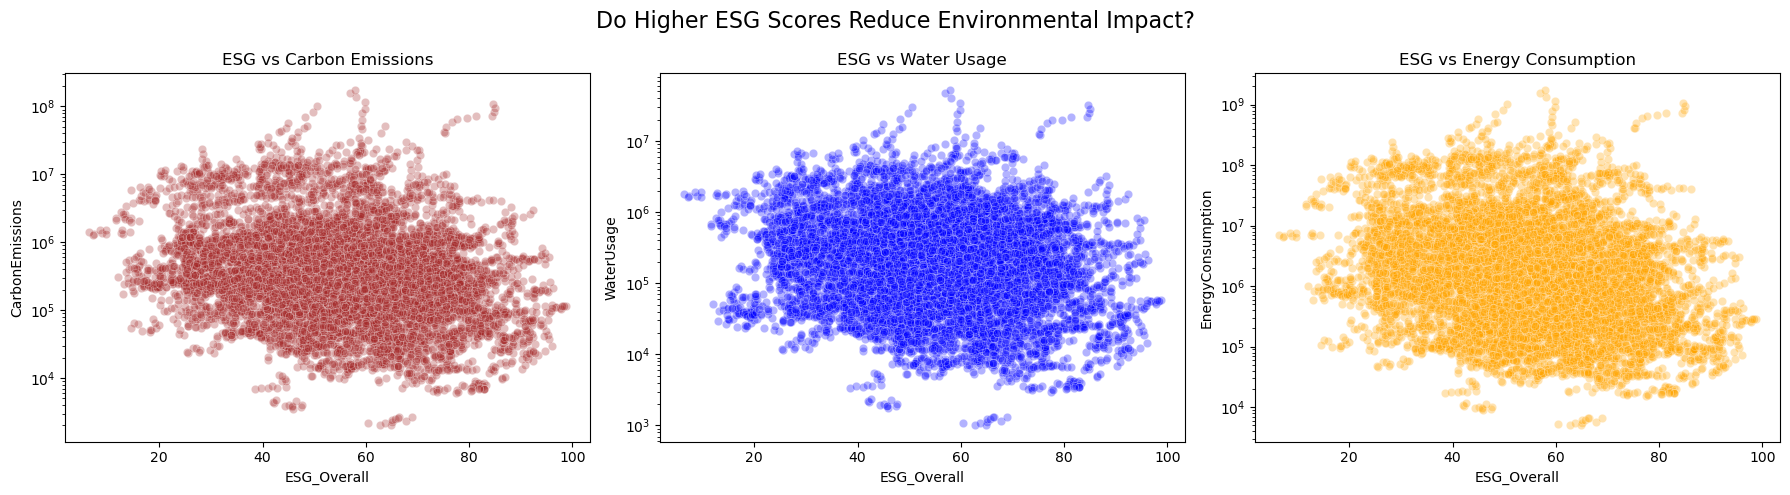

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(ax=axes[0], data=Merged, x='ESG_Overall', y='CarbonEmissions', color='brown', alpha=0.3)
axes[0].set_title('ESG vs Carbon Emissions')
axes[0].set_yscale('log')

sns.scatterplot(ax=axes[1], data=Merged, x='ESG_Overall', y='WaterUsage', color='blue', alpha=0.3)
axes[1].set_title('ESG vs Water Usage')
axes[1].set_yscale('log')

sns.scatterplot(ax=axes[2], data=Merged, x='ESG_Overall', y='EnergyConsumption', color='orange', alpha=0.3)
axes[2].set_title('ESG vs Energy Consumption')
axes[2].set_yscale('log')

plt.suptitle('Do Higher ESG Scores Reduce Environmental Impact?', fontsize=16)
plt.tight_layout()
plt.show()

### Scatter plot of Average Regional GDP vs. Average ESG Score

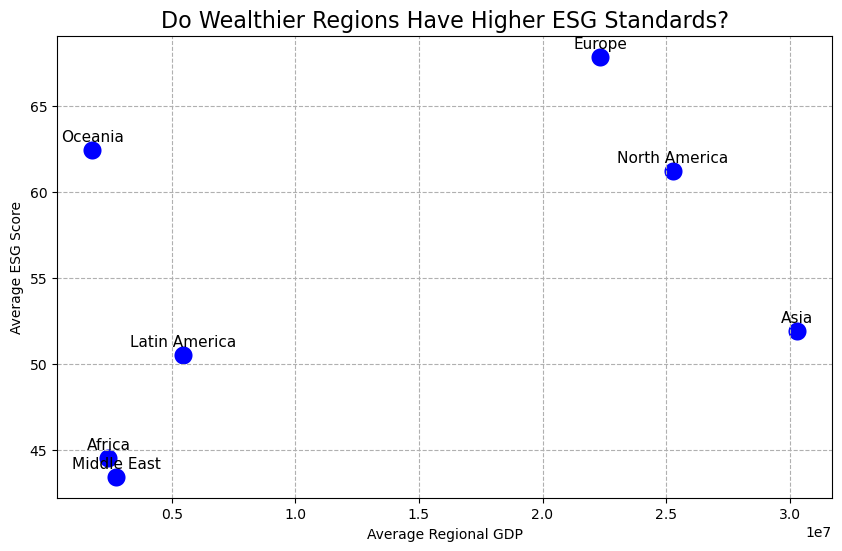

In [22]:
regional_summary = Merged.groupby('Region')[['GDP', 'ESG_Overall']].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=regional_summary, x='GDP', y='ESG_Overall', s=200, color='blue')

for i in range(regional_summary.shape[0]):
    plt.text(regional_summary.GDP[i], regional_summary.ESG_Overall[i]+0.5,
             regional_summary.Region[i], fontsize=11, ha='center')

plt.title('Do Wealthier Regions Have Higher ESG Standards?', fontsize=16)
plt.xlabel('Average Regional GDP')
plt.ylabel('Average ESG Score')
plt.grid(True, linestyle='--')
plt.show()

### Box Plots of Profit Margin by Industry (sorted high-to-low)


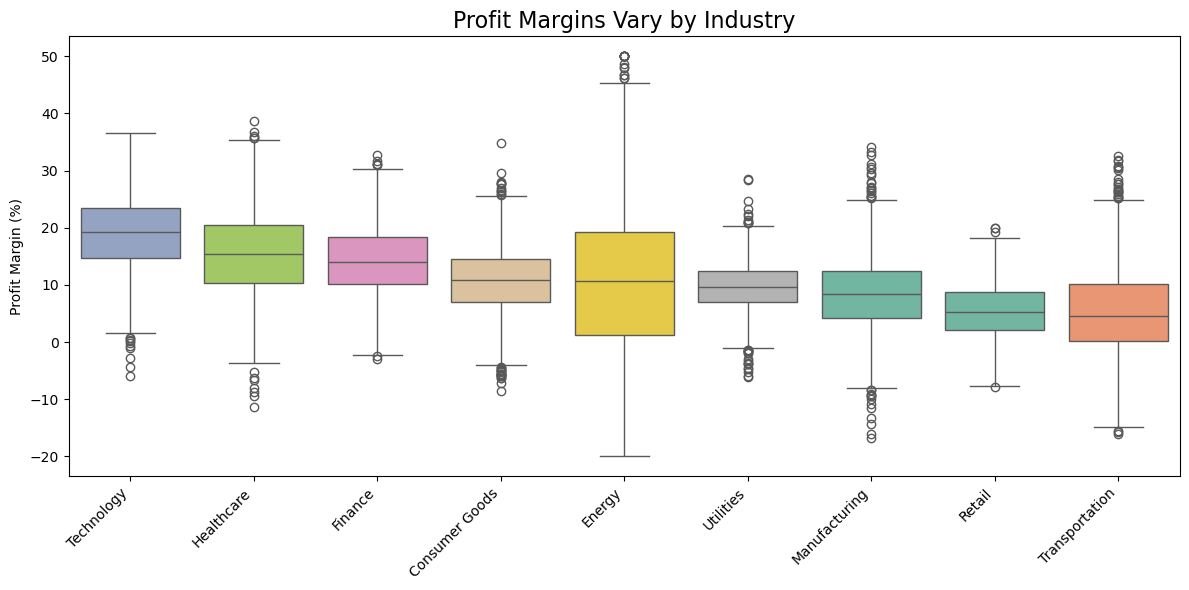

In [24]:
plt.figure(figsize=(12, 6))

sorted_index = Merged.groupby('Industry')['ProfitMargin'].median().sort_values(ascending=False).index

sns.boxplot(data=Merged, x='Industry', y='ProfitMargin', hue='Industry', order=sorted_index, palette='Set2',legend=False)
plt.title('Profit Margins Vary by Industry', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Profit Margin (%)')
plt.xlabel('')
plt.tight_layout()
plt.show()

### Correlation Matrix 

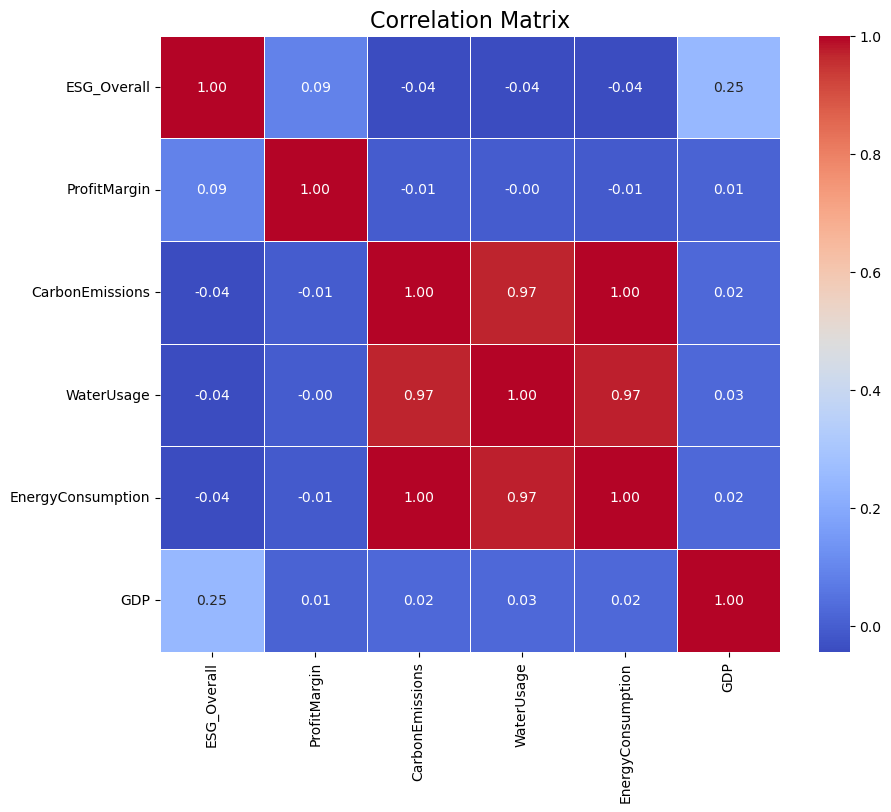

In [26]:
plt.figure(figsize=(10, 8))
numeric_cols = ['ESG_Overall', 'ProfitMargin', 'CarbonEmissions', 'WaterUsage', 'EnergyConsumption', 'GDP']
corr_matrix = Merged[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

# STATISTICAL INFERENCE (HYPOTHESIS TESTING)


- **H0 (Null Hypothesis):** ESG performance has no meaningful relationship with financial or environmental outcomes.
- **H1 (Alternative Hypothesis):** Companies with **higher ESG performance** tend to exhibit **better financial performance** (e.g., higher ProfitMargin) and **lower environmental impact** (e.g., lower CarbonEmissions, WaterUsage, EnergyConsumption).


In order to validate visual trends, I applied formal hypothesis tests (p < 0.05):

- **Pearson Correlation (r):**                                                
  - Tested the linear relationship between ESG_Overall and ProfitMargin.Tested ESG_Overall against all three environmental metrics (Carbon, Water, Energy)
- **Independent T-Test:**
  - Compared ESG scores between "High GDP" and "Low GDP" regions to determine if economic maturity is a confounding variable.

### ESG Score vs. Profit Margin

In [31]:
# Cleaned the data specifically for this pair
esg_profit_data = Merged.dropna(subset=['ESG_Overall', 'ProfitMargin'])
corr_coef, p_value = pearsonr(esg_profit_data['ESG_Overall'], esg_profit_data['ProfitMargin'])

print("\nPearson Correlation (r): {:.4f}".format(corr_coef))
print("P-value:                 {:.4e}".format(p_value))

if p_value < 0.05:
    if corr_coef > 0:
        print("\nReject H0 (Significant relationship).")
        print("Higher ESG scores correlate with higher profit margins.")
    else:
        print("Interpretation: Higher ESG scores correlate with LOWER profit margins.")
else:
    print("\nFAIL TO REJECT H0 (No significant relationship).")
    print("ESG scores do not meaningfully predict profit margins.")



Pearson Correlation (r): 0.0880
P-value:                 2.3069e-20

Reject H0 (Significant relationship).
Higher ESG scores correlate with higher profit margins.


### ESG Score vs. Environmental Impact

In [33]:
metrics = ['CarbonEmissions', 'WaterUsage', 'EnergyConsumption']

for metric in metrics:
    metric_data = Merged.dropna(subset=['ESG_Overall', metric])
    corr, p_val = pearsonr(metric_data['ESG_Overall'], metric_data[metric])

    print("\nTarget Variable: {}".format(metric))
    print("Correlation (r): {:.4f}".format(corr))
    print("P-value:         {:.4e}".format(p_val))

    if p_val < 0.05:
        if corr < 0:
            print("\nReject H0 (Significant relationship).")
            print("Higher ESG scores are linked to lower {}.".format(metric))
        else:
            print("Higher ESG scores are linked to HIGHER {}.".format(metric))
    else:
        print("\nFAIL TO REJECT H0 (No significant relationship).")
        print("No clear link between ESG and {}.".format(metric))


Target Variable: CarbonEmissions
Correlation (r): -0.0397
P-value:         3.1543e-05

Reject H0 (Significant relationship).
Higher ESG scores are linked to lower CarbonEmissions.

Target Variable: WaterUsage
Correlation (r): -0.0429
P-value:         6.7273e-06

Reject H0 (Significant relationship).
Higher ESG scores are linked to lower WaterUsage.

Target Variable: EnergyConsumption
Correlation (r): -0.0436
P-value:         4.6587e-06

Reject H0 (Significant relationship).
Higher ESG scores are linked to lower EnergyConsumption.


### Does Wealthier Regions Have Higher ESG Scores?

In [35]:
# Define High vs. Low GDP groups
gdp_median = Merged['GDP'].median()
high_gdp_group = Merged[Merged['GDP'] > gdp_median]['ESG_Overall']
low_gdp_group = Merged[Merged['GDP'] <= gdp_median]['ESG_Overall']

# Run T-test
t_stat, p_value_gdp = ttest_ind(high_gdp_group, low_gdp_group, equal_var=False)

print("\nT-statistic: {:.4f}".format(t_stat))
print("P-value: {:.4e}".format(p_value_gdp))

if p_value_gdp < 0.05:
    if t_stat > 0:
        print("\nReject H0 (Significant relationship).")
        print("Wealthier regions have significantly higher ESG scores.")
    else:
        print("\nLower GDP regions actually have higher ESG scores.")
else:
    print("\nFAIL TO REJECT H0 (No significant relationship).")
    print("\nRegional wealth does not dictate ESG performance.")



T-statistic: 30.3905
P-value: 7.4433e-195

Reject H0 (Significant relationship).
Wealthier regions have significantly higher ESG scores.


# Data Analysis Conclusion 

Based on the visualizations and statistical tests in this notebook, several consistent patterns emerge:

**1. ESG Score vs. Profit Margin**

- Pearson correlation is positive and significant (r ≈ 0.088, p < 0.001).
- Higher ESG scores are weak but statistically associated with higher profit margins.

**2. ESG Scores Across Regions**

- High-GDP regions show significantly higher ESG scores (t-test p ≈ 0).
- Wealthier economies tend to enforce stronger sustainability standards.

**3. ESG Score vs. Environmental Impact**

- Carbon Emissions, Water Usage, and Energy Consumption all show small but significant negative correlations with ESG.
- Companies with higher ESG performance generally operate with lower environmental footprint.

**4. Industry Profitability Differences**

- Profit margins vary widely across industries.
- ESG–financial relationships should always be interpreted within each industry’s specific context.

**5. Correlation Matrix**
   
- The correlation matrix summarizes the linear relationships between ESG performance, financial outcomes, environmental impact, and regional GDP.

- ESG_Overall and ProfitMargin show a weak but positive correlation (r ≈ 0.09), consistent with the pattern observed in the ESG vs. ProfitMargin visualization.

- ESG_Overall exhibits negative correlations with environmental impact metrics, indicating that companies with stronger ESG performance tend to operate with lower overall environmental footprint.

- Environmental impact variables are strongly correlated with each other, suggesting that firms with high emissions also tend to have higher water and energy usage, and should therefore be interpreted jointly.

- Regional GDP shows a moderate positive correlation with ESG_Overall (r ≈ 0.25), reinforcing its role as a contextual regional factor rather than a direct driver of firm-level profitability.

# Overall Summary

Taken together, the results confirm the main expectations of the project:

 - higher ESG scores tend to correspond to lower emissions and higher efficiency,

 - ESG–profitability patterns differ across industries and regions, and

 - sustainability alignment is stronger in wealthier economies.

Overall, the data supports the idea that ESG is not only an ethical framework, but a meaningful indicator of operational efficiency and long-term corporate resilience, particularly in developed economies.

# Machine Learning Applications


### Importing necessary libraries

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 1. Predictive Modeling (Regression)

- Defined features (X) and target (y)
- Split the data into training and testing sets (80/20 split)
- Applied standardization to ensure all features are on the same scale
    - Scaling was applied only where needed (linear regression); tree models do not require scaling.

Trained three models:
1. **Baseline (Dummy):** Guesses the average profit.
2. **Linear Regression:** Checks for linear relationships.
3. **Random Forest:** Captures complex, non-linear patterns.
   
Compared them using RMSE (Root Mean Squared Error) and $R^2$.

**Feature Importance:** Using the Random Forest model, visualized which features actually drive the predictions.

In [41]:
features = ['ESG_Overall', 'CarbonEmissions', 'WaterUsage', 'EnergyConsumption', 'GDP']
target = 'ProfitMargin'

X = Merged[features]
y = Merged[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train) 

print(f"{'Model':<20} | {'RMSE':<10} | {'R² Score':<10}")
print("-" * 45)

for name, model, data in [('Baseline (Mean)', dummy_model, X_test), ('Linear Regression', lr_model, X_test_scaled), ('Random Forest', rf_model, X_test)]:
    preds = model.predict(data)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"{name:<20} | {rmse:<10.4f} | {r2:<10.4f}")

Model                | RMSE       | R² Score  
---------------------------------------------
Baseline (Mean)      | 8.9234     | -0.0002   
Linear Regression    | 8.9303     | -0.0017   
Random Forest        | 6.7360     | 0.4301    


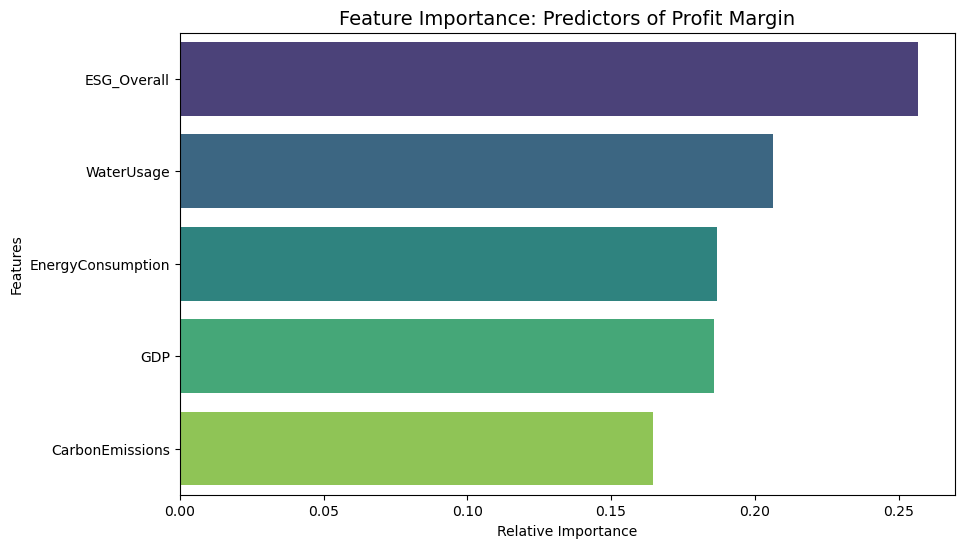

In [43]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X.columns[indices], hue=X.columns[indices], palette="viridis")
plt.title("Feature Importance: Predictors of Profit Margin", fontsize=14)
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.show()


### 2. Clustering Analysis (Sustainability Profiles)
- Applied Z-score standardization (StandardScaler) to ESG_Overall and ProfitMargin to normalize their scales, ensuring that the large numerical difference between ESG scores (0–100) and profit percentages (0–1) did not bias the K-Means clustering distances.
- Used **K-Means Clustering** to find natural groups in the data. To pick the best number of clusters ($k$)
- Used both the **Elbow Method** (Inertia) and **Silhouette Score**
- Based on metrics, fitted the final K-Means model, visualized the groups, interpreted their characteristics by calculating average values.
    - k=3 selected because it provides a strong silhouette score while keeping clusters interpretable (supported by elbow trend).

In [45]:
cluster_features = ['ESG_Overall', 'ProfitMargin']
X_cluster = Merged[cluster_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

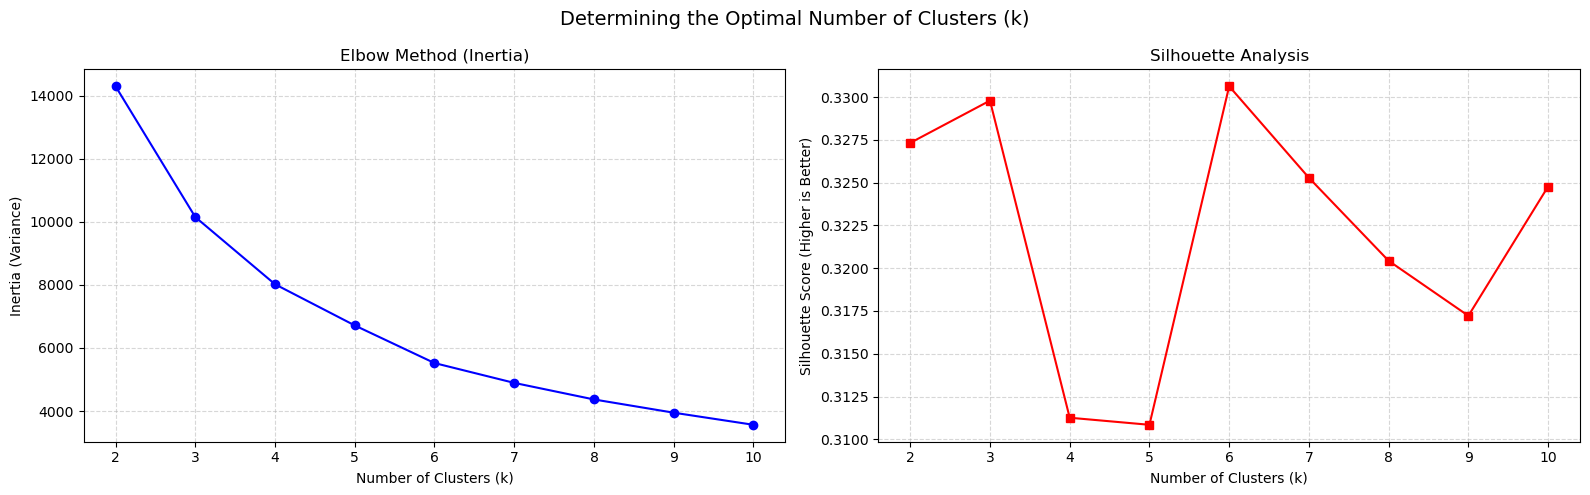

In [46]:
# Find the optimal 'K' (number of clusters)
inertia = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(16, 5)) 

# Elbow Method (Inertia)
axes[0].plot(K_range, inertia, marker='o', linestyle='-', color='blue')
axes[0].set_title('Elbow Method (Inertia)')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Variance)')
axes[0].grid(True, linestyle='--', alpha=0.5)

# Silhouette Score
axes[1].plot(K_range, silhouettes, marker='s', linestyle='-', color='red')
axes[1].set_title('Silhouette Analysis')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score (Higher is Better)')
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Determining the Optimal Number of Clusters (k)', fontsize=14)
plt.tight_layout()
plt.show()

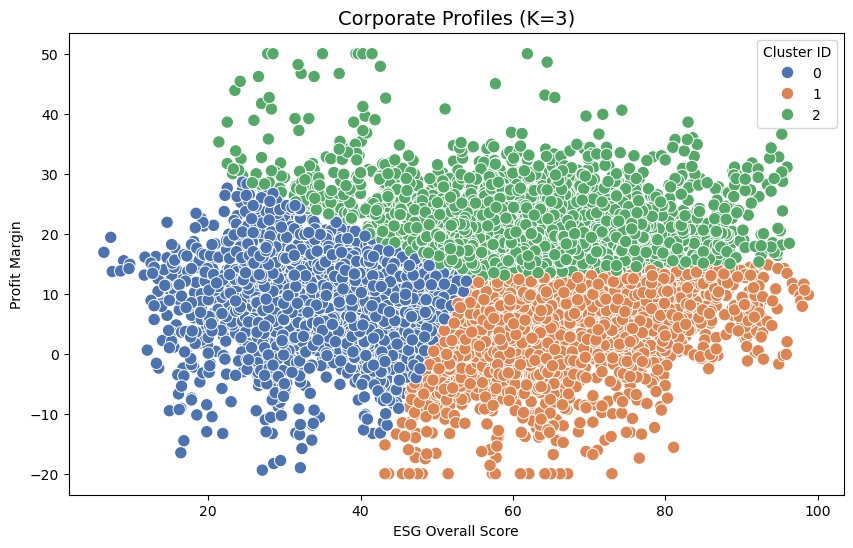

In [47]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
Merged['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=Merged, x='ESG_Overall', y='ProfitMargin', hue='Cluster', palette='deep', s=80)
plt.title(f'Corporate Profiles (K={optimal_k})', fontsize=14)
plt.xlabel('ESG Overall Score')
plt.ylabel('Profit Margin')
plt.legend(title='Cluster ID')
plt.show()

In [48]:
profile = Merged.groupby('Cluster')[['ESG_Overall', 'ProfitMargin']].mean().reset_index()
print("CLUSTER PROFILES (Average Values)")
print("-" * 50)
print(profile)

CLUSTER PROFILES (Average Values)
--------------------------------------------------
   Cluster  ESG_Overall  ProfitMargin
0        0    38.908671      8.590997
1        1    65.118902      5.146275
2        2    61.194622     20.447203


# Machine Learning Applications Conclusion

Based on the predictive modeling and clustering analyses conducted in this project, the following key insights emerge:

**1. Predictive Modeling Performance**

- The baseline (Dummy) model performs poorly (R² ≈ 0), confirming that simply predicting the mean profit margin provides no explanatory power.

- Multiple Linear Regression does not improve upon the baseline (negative R²), indicating that the relationship between ESG, environmental indicators, and profit margin is not purely linear.

- The Random Forest Regressor substantially outperforms both baselines, achieving:
    
    - Lower RMSE
    - Meaningful explanatory power (R² ≈ 0.43)

This demonstrates that non-linear interactions between ESG, environmental metrics, and regional context play an important role in explaining profitability.

**2. Feature Importance Insights**

- ESG_Overall emerges as the most influential predictor of Profit Margin in the Random Forest model.

- Environmental indicators (Water Usage, Energy Consumption, Carbon Emissions) also contribute meaningfully, reinforcing the link between operational efficiency and financial performance.

- Regional GDP plays a secondary but relevant role, acting as a contextual factor rather than a direct firm-level driver.

Overall, the feature importance analysis supports the hypothesis that sustainability-related variables jointly influence profitability, rather than any single factor acting in isolation.

**3. Clustering Analysis (Sustainability Profiles)**

- Using K-Means Clustering, firms naturally separate into three distinct sustainability–performance profiles, validated through both:

    - The Elbow Method
    - Silhouette Score analysis


- The resulting clusters reveal:

    - Cluster 0: A low-ESG (39) and moderate-profit (8.5%) group
    - Cluster 1: A high-ESG (65) and lowest-profit (5.1%) group
    - Cluster 2: A high-ESG (61) and highest-profit (20.4%) group
 
These patterns suggest that companies adopt different sustainability strategies, and that high ESG performance can coexist with strong financial outcomes, rather than implying a uniform trade-off.

# Overall Summary

Taken together, the machine learning results reinforce and extend the findings from the exploratory and statistical analyses:

- ESG performance is not a simple linear predictor of profitability, but it plays a central role in more flexible, non-linear models.

- Firms cluster into distinct sustainability–profitability profiles, highlighting strategic heterogeneity rather than a one-size-fits-all relationship.

- Sustainability metrics, when analyzed jointly with environmental and contextual variables, provide meaningful predictive and descriptive insight into corporate financial performance.

Overall, the machine learning analysis supports the view that ESG is not only ethically relevant but also structurally embedded in corporate performance dynamics, particularly when complex interactions are properly modeled.